In [1]:
!pip install dataset
!pip install transformers
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.19
    Uninstalling SQLAlchemy-2.0.19:
      Successfully uninstalled SQLAlchemy-2.0.19
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.4 MB/s eta 0:00:00


In [1]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data loading

In [2]:
df_dev = load_dataset("csv", data_files="subtaskA_clean_dev_cased.csv")
df_test = load_dataset("csv", data_files="subtaskA_clean_test_cased.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

# Data partioning

In [3]:
train_val = df_dev['train'].train_test_split(test_size=0.3, seed=42)
train_val

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 1288
    })
    test: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 552
    })
})

In [4]:
df_train = train_val["train"]
df_val = train_val["test"]

In [5]:
df_train = df_train.rename_column("comment_text", "text")
df_train = df_train.rename_column("conspiratorial", "labels")
df_val = df_val.rename_column("comment_text", "text")
df_val = df_val.rename_column("conspiratorial", "labels")
df_test = df_test.rename_column("comment_text", "text")

# Data preprocessing

In [6]:
model_name = 'xlm-roberta-base' # modificare

In [7]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [9]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
tokenized_test = df_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/1288 [00:00<?, ? examples/s]

Map:   0%|          | 0/552 [00:00<?, ? examples/s]

Map:   0%|          | 0/460 [00:00<?, ? examples/s]

In [11]:
#small_train_dataset = tokenized_train.shuffle(seed=42).select(range(6))
#small_eval_dataset = tokenized_val.shuffle(seed=42).select(range(3))

# Training

In [10]:
training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned",
    evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
    save_strategy = "epoch",
    logging_strategy="epoch",
    num_train_epochs=15,
    load_best_model_at_end=True # the best model might not be the one at the end of training => we load the best saved model
    #per_device_train_batch_size # default 8
    #per_device_eval_batch_size # default 8
    #learning_rate=0.0005, # default 0.00005
    #weight_decay=0.0001 # default 0 # disastro
    )

In [11]:
config = AutoConfig.from_pretrained(model_name)

In [14]:
# config.dropout = 0.001

In [12]:
print(config)

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}



In [13]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name)

In [14]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [15]:
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Hyperparameters search

In [16]:
!pip install ray[tune]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 12.2 MB/s eta 0:00:00


In [18]:
%%time
best_run = trainer.hyperparameter_search(n_trials=5)

2023-08-04 16:58:15,439	INFO worker.py:1621 -- Started a local Ray instance.
2023-08-04 16:58:28,670	INFO tune.py:226 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2023-08-04 16:58:28,700	INFO tune.py:666 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/function_trainable.py:624: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/latest/tun

+-------------------------------------------------------------------+
| Configuration for experiment     _objective_2023-08-04_16-58-28   |
+-------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator            |
| Scheduler                        FIFOScheduler                    |
| Number of trials                 5                                |
+-------------------------------------------------------------------+

View detailed results here: /root/ray_results/_objective_2023-08-04_16-58-28
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_objective_2023-08-04_16-58-28`

Trial status: 5 PENDING
Current time: 2023-08-04 16:58:28. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs
+--------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epoc

(pid=3132) 2023-08-04 16:58:36.292604: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Trial _objective_22784_00000 started with configuration:
+-------------------------------------------------+
| Trial _objective_22784_00000 config             |
+-------------------------------------------------+
| learning_rate                             1e-05 |
| num_train_epochs                              5 |
| per_device_train_batch_size                  64 |
| seed                                    8.15396 |
+-------------------------------------------------+



(_objective pid=3132) Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
(_objective pid=3132) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=3132) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=3132)   warnings.warn(
  0%|          | 0/105 [00:00<?, ?it/s]
2023-08-04 16:58:51,288	ERROR tune_controller.py:911 -- Trial task failed for trial _objective_22784_00000
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/a

Trial status: 1 ERROR | 4 PENDING
Current time: 2023-08-04 16:58:59. Total running time: 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+--------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs       seed     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------------------+
| _objective_22784_00001   PENDING        1.56207e-05                    2    7.08379                       16 |
| _objective_22784_00002   PENDING        8.28892e-06                    5   24.4435                        16 |
| _objective_22784_00003   PENDING        1.09943e-06                    2   29.158                          8 |
| _objective_22784_00004   PENDING        2.3102e-06                     5   25.0818                         8 |
| _objective_22784_00000   ERROR          5.61152e-06                

(_objective pid=3260) Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
(_objective pid=3260) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=3260) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=3260)   warnings.warn(
  1%|          | 1/162 [00:01<05:02,  1.88s/it]
2023-08-04 16:59:07,693	ERROR tune_controller.py:911 -- Trial task failed for trial _objective_22784_00001
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packag

Trial _objective_22784_00002 started with configuration:
+-------------------------------------------------+
| Trial _objective_22784_00002 config             |
+-------------------------------------------------+
| learning_rate                             1e-05 |
| num_train_epochs                              5 |
| per_device_train_batch_size                  16 |
| seed                                    24.4435 |
+-------------------------------------------------+



(_objective pid=3360) Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
(_objective pid=3360) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=3360) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=3360)   warnings.warn(
  0%|          | 1/405 [00:01<11:35,  1.72s/it]
2023-08-04 16:59:23,961	ERROR tune_controller.py:911 -- Trial task failed for trial _objective_22784_00002
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packag

Trial status: 3 ERROR | 2 PENDING
Current time: 2023-08-04 16:59:29. Total running time: 1min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+--------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs       seed     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------------------+
| _objective_22784_00003   PENDING        1.09943e-06                    2   29.158                          8 |
| _objective_22784_00004   PENDING        2.3102e-06                     5   25.0818                         8 |
| _objective_22784_00000   ERROR          5.61152e-06                    5    8.15396                       64 |
| _objective_22784_00001   ERROR          1.56207e-05                    2    7.08379                       16 |
| _objective_22784_00002   ERROR          8.28892e-06            

(pid=3455) 2023-08-04 16:59:30.834093: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Trial _objective_22784_00003 started with configuration:
+-------------------------------------------------+
| Trial _objective_22784_00003 config             |
+-------------------------------------------------+
| learning_rate                                 0 |
| num_train_epochs                              2 |
| per_device_train_batch_size                   8 |
| seed                                    29.1579 |
+-------------------------------------------------+



(_objective pid=3455) Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
(_objective pid=3455) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=3455) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=3455)   warnings.warn(
  9%|▊         | 28/322 [00:21<03:42,  1.32it/s]


Trial status: 3 ERROR | 1 RUNNING | 1 PENDING
Current time: 2023-08-04 16:59:59. Total running time: 1min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+--------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs       seed     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------------------+
| _objective_22784_00003   RUNNING        1.09943e-06                    2   29.158                          8 |
| _objective_22784_00004   PENDING        2.3102e-06                     5   25.0818                         8 |
| _objective_22784_00000   ERROR          5.61152e-06                    5    8.15396                       64 |
| _objective_22784_00001   ERROR          1.56207e-05                    2    7.08379                       16 |
| _objective_22784_00002   ERROR          8.28892e-0

 21%|██        | 67/322 [00:51<03:16,  1.30it/s]


Trial status: 3 ERROR | 1 RUNNING | 1 PENDING
Current time: 2023-08-04 17:00:29. Total running time: 2min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+--------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs       seed     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------------------+
| _objective_22784_00003   RUNNING        1.09943e-06                    2   29.158                          8 |
| _objective_22784_00004   PENDING        2.3102e-06                     5   25.0818                         8 |
| _objective_22784_00000   ERROR          5.61152e-06                    5    8.15396                       64 |
| _objective_22784_00001   ERROR          1.56207e-05                    2    7.08379                       16 |
| _objective_22784_00002   ERROR          8.28892e-06

 33%|███▎      | 105/322 [01:20<02:49,  1.28it/s]


Trial status: 3 ERROR | 1 RUNNING | 1 PENDING
Current time: 2023-08-04 17:00:59. Total running time: 2min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+--------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs       seed     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------------------+
| _objective_22784_00003   RUNNING        1.09943e-06                    2   29.158                          8 |
| _objective_22784_00004   PENDING        2.3102e-06                     5   25.0818                         8 |
| _objective_22784_00000   ERROR          5.61152e-06                    5    8.15396                       64 |
| _objective_22784_00001   ERROR          1.56207e-05                    2    7.08379                       16 |
| _objective_22784_00002   ERROR          8.28892e-0

 45%|████▍     | 144/322 [01:51<02:17,  1.30it/s]


Trial status: 3 ERROR | 1 RUNNING | 1 PENDING
Current time: 2023-08-04 17:01:29. Total running time: 3min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+--------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs       seed     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------------------+
| _objective_22784_00003   RUNNING        1.09943e-06                    2   29.158                          8 |
| _objective_22784_00004   PENDING        2.3102e-06                     5   25.0818                         8 |
| _objective_22784_00000   ERROR          5.61152e-06                    5    8.15396                       64 |
| _objective_22784_00001   ERROR          1.56207e-05                    2    7.08379                       16 |
| _objective_22784_00002   ERROR          8.28892e-06

 50%|█████     | 161/322 [02:04<02:04,  1.29it/s]


(_objective pid=3455) {'loss': 0.6953, 'learning_rate': 5.49716778738311e-07, 'epoch': 1.0}


(_objective pid=3455) 
  0%|          | 0/69 [00:00<?, ?it/s]
(_objective pid=3455) 
  3%|▎         | 2/69 [00:00<00:07,  8.73it/s]
(_objective pid=3455) 
  4%|▍         | 3/69 [00:00<00:10,  6.05it/s]
(_objective pid=3455) 
  6%|▌         | 4/69 [00:00<00:12,  5.24it/s]
(_objective pid=3455) 
  7%|▋         | 5/69 [00:00<00:13,  4.85it/s]
(_objective pid=3455) 
  9%|▊         | 6/69 [00:01<00:13,  4.68it/s]
(_objective pid=3455) 
 10%|█         | 7/69 [00:01<00:13,  4.57it/s]
(_objective pid=3455) 
 12%|█▏        | 8/69 [00:01<00:13,  4.49it/s]
(_objective pid=3455) 
 13%|█▎        | 9/69 [00:01<00:13,  4.39it/s]
(_objective pid=3455) 
 14%|█▍        | 10/69 [00:02<00:13,  4.36it/s]
(_objective pid=3455) 
 16%|█▌        | 11/69 [00:02<00:13,  4.35it/s]
(_objective pid=3455) 
 17%|█▋        | 12/69 [00:02<00:13,  4.38it/s]
(_objective pid=3455) 
 19%|█▉        | 13/69 [00:02<00:12,  4.39it/s]
(_objective pid=3455) 
 20%|██        | 14/69 [00:03<00:12,  4.40it/s]
(_objective pid=3455) 


Trial status: 3 ERROR | 1 RUNNING | 1 PENDING
Current time: 2023-08-04 17:01:59. Total running time: 3min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+--------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs       seed     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------------------+
| _objective_22784_00003   RUNNING        1.09943e-06                    2   29.158                          8 |
| _objective_22784_00004   PENDING        2.3102e-06                     5   25.0818                         8 |
| _objective_22784_00000   ERROR          5.61152e-06                    5    8.15396                       64 |
| _objective_22784_00001   ERROR          1.56207e-05                    2    7.08379                       16 |
| _objective_22784_00002   ERROR          8.28892e-0

(_objective pid=3455) 
(_objective pid=3455) 
                                                 
100%|██████████| 69/69 [00:17<00:00,  4.00it/s]
                                               


Trial _objective_22784_00003 finished iteration 1 at 2023-08-04 17:01:59. Total running time: 3min 30s
+-------------------------------------------------+
| Trial _objective_22784_00003 result             |
+-------------------------------------------------+
| time_this_iter_s                        147.849 |
| time_total_s                            147.849 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_f1                                 0.35261 |
| eval_loss                               0.69271 |
| eval_runtime                            17.6308 |
| eval_samples_per_second                  31.309 |
| eval_steps_per_second                     3.914 |
| objective                               0.35261 |
+-------------------------------------------------+

(_objective pid=3455) {'eval_loss': 0.6927088499069214, 'eval_f1': 0.35260726973417666, 'eval_runtime': 17.6308, 'eval_samples_per_second': 31.309, 'eval_steps_per_seco

 62%|██████▏   | 200/322 [03:21<01:35,  1.27it/s]


Trial status: 3 ERROR | 1 RUNNING | 1 PENDING
Current time: 2023-08-04 17:02:59. Total running time: 4min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00003   RUNNING        1.09943e-06                    2   29.158                          8        1            147.849      0.352607      0.692709    0.352607          17.6308 |
| _objective_22784_00004   PENDING        2.3102e-0

 74%|███████▍  | 238/322 [03:50<01:05,  1.29it/s]


Trial status: 3 ERROR | 1 RUNNING | 1 PENDING
Current time: 2023-08-04 17:03:29. Total running time: 5min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00003   RUNNING        1.09943e-06                    2   29.158                          8        1            147.849      0.352607      0.692709    0.352607          17.6308 |
| _objective_22784_00004   PENDING        2.3102e-06

 86%|████████▌ | 277/322 [04:20<00:34,  1.29it/s]


Trial status: 3 ERROR | 1 RUNNING | 1 PENDING
Current time: 2023-08-04 17:03:59. Total running time: 5min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00003   RUNNING        1.09943e-06                    2   29.158                          8        1            147.849      0.352607      0.692709    0.352607          17.6308 |
| _objective_22784_00004   PENDING        2.3102e-0

 98%|█████████▊| 316/322 [04:51<00:04,  1.28it/s]


Trial status: 3 ERROR | 1 RUNNING | 1 PENDING
Current time: 2023-08-04 17:04:29. Total running time: 6min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00003   RUNNING        1.09943e-06                    2   29.158                          8        1            147.849      0.352607      0.692709    0.352607          17.6308 |
| _objective_22784_00004   PENDING        2.3102e-06

100%|██████████| 322/322 [04:55<00:00,  1.28it/s]


(_objective pid=3455) {'loss': 0.6843, 'learning_rate': 0.0, 'epoch': 2.0}


(_objective pid=3455) 
  0%|          | 0/69 [00:00<?, ?it/s]
(_objective pid=3455) 
  3%|▎         | 2/69 [00:00<00:07,  8.57it/s]
(_objective pid=3455) 
  4%|▍         | 3/69 [00:00<00:10,  6.11it/s]
(_objective pid=3455) 
  6%|▌         | 4/69 [00:00<00:12,  5.25it/s]
(_objective pid=3455) 
  7%|▋         | 5/69 [00:00<00:13,  4.89it/s]
(_objective pid=3455) 
  9%|▊         | 6/69 [00:01<00:13,  4.70it/s]
(_objective pid=3455) 
 10%|█         | 7/69 [00:01<00:13,  4.61it/s]
(_objective pid=3455) 
 12%|█▏        | 8/69 [00:01<00:13,  4.52it/s]
(_objective pid=3455) 
 13%|█▎        | 9/69 [00:01<00:13,  4.45it/s]
(_objective pid=3455) 
 14%|█▍        | 10/69 [00:02<00:13,  4.43it/s]
(_objective pid=3455) 
 16%|█▌        | 11/69 [00:02<00:13,  4.42it/s]
(_objective pid=3455) 
 17%|█▋        | 12/69 [00:02<00:12,  4.42it/s]
(_objective pid=3455) 
 19%|█▉        | 13/69 [00:02<00:12,  4.40it/s]
(_objective pid=3455) 
 20%|██        | 14/69 [00:02<00:12,  4.39it/s]
(_objective pid=3455) 


Trial _objective_22784_00003 finished iteration 2 at 2023-08-04 17:04:50. Total running time: 6min 21s
+-------------------------------------------------+
| Trial _objective_22784_00003 result             |
+-------------------------------------------------+
| time_this_iter_s                        170.421 |
| time_total_s                             318.27 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_f1                                 0.38162 |
| eval_loss                               0.69002 |
| eval_runtime                            16.4549 |
| eval_samples_per_second                  33.546 |
| eval_steps_per_second                     4.193 |
| objective                               0.38162 |
+-------------------------------------------------+

(_objective pid=3455) {'eval_loss': 0.6900204420089722, 'eval_f1': 0.38162046820821105, 'eval_runtime': 16.4549, 'eval_samples_per_second': 33.546, 'eval_steps_per_seco

                                                 
100%|██████████| 69/69 [00:16<00:00,  4.34it/s]
                                               


Trial status: 3 ERROR | 1 RUNNING | 1 PENDING
Current time: 2023-08-04 17:04:59. Total running time: 6min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00003   RUNNING        1.09943e-06                    2   29.158                          8        2             318.27       0.38162       0.69002     0.38162          16.4549 |
| _objective_22784_00004   PENDING        2.3102e-0

100%|██████████| 322/322 [05:50<00:00,  1.09s/it]


Trial status: 3 ERROR | 1 TERMINATED | 1 PENDING
Current time: 2023-08-04 17:05:29. Total running time: 7min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00003   TERMINATED       1.09943e-06                    2   29.158                          8        2             318.27       0.38162       0.69002     0.38162          16.4549 |
| _objective_22784_00004   PENDING       

(pid=5032) 2023-08-04 17:05:36.216200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Trial _objective_22784_00004 started with configuration:
+-------------------------------------------------+
| Trial _objective_22784_00004 config             |
+-------------------------------------------------+
| learning_rate                                 0 |
| num_train_epochs                              5 |
| per_device_train_batch_size                   8 |
| seed                                    25.0818 |
+-------------------------------------------------+



(_objective pid=5032) Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
(_objective pid=5032) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=5032) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=5032)   warnings.warn(
  2%|▏         | 15/805 [00:11<10:11,  1.29it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:05:59. Total running time: 7min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8                                                                                      |
| _objective_22784_00003   TERMINATED   

  7%|▋         | 54/805 [00:42<09:53,  1.27it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:06:29. Total running time: 8min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8                                                                                      |
| _objective_22784_00003   TERMINATED    

 11%|█▏        | 92/805 [01:11<09:09,  1.30it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:06:59. Total running time: 8min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8                                                                                      |
| _objective_22784_00003   TERMINATED   

 16%|█▋        | 131/805 [01:42<08:39,  1.30it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:07:29. Total running time: 9min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8                                                                                      |
| _objective_22784_00003   TERMINATED    

 20%|██        | 161/805 [02:05<08:18,  1.29it/s]


(_objective pid=5032) {'loss': 0.6795, 'learning_rate': 1.8481615102762364e-06, 'epoch': 1.0}


(_objective pid=5032) 
  0%|          | 0/69 [00:00<?, ?it/s]
(_objective pid=5032) 
  3%|▎         | 2/69 [00:00<00:07,  8.52it/s]
(_objective pid=5032) 
  4%|▍         | 3/69 [00:00<00:11,  5.94it/s]
(_objective pid=5032) 
  6%|▌         | 4/69 [00:00<00:12,  5.16it/s]
(_objective pid=5032) 
  7%|▋         | 5/69 [00:00<00:13,  4.82it/s]
(_objective pid=5032) 
  9%|▊         | 6/69 [00:01<00:13,  4.60it/s]
(_objective pid=5032) 
 10%|█         | 7/69 [00:01<00:13,  4.52it/s]
(_objective pid=5032) 
 12%|█▏        | 8/69 [00:01<00:13,  4.42it/s]
(_objective pid=5032) 
 13%|█▎        | 9/69 [00:01<00:13,  4.38it/s]
(_objective pid=5032) 
 14%|█▍        | 10/69 [00:02<00:13,  4.35it/s]
(_objective pid=5032) 
 16%|█▌        | 11/69 [00:02<00:13,  4.35it/s]
(_objective pid=5032) 
 17%|█▋        | 12/69 [00:02<00:13,  4.34it/s]
(_objective pid=5032) 
 19%|█▉        | 13/69 [00:02<00:12,  4.35it/s]
(_objective pid=5032) 
 20%|██        | 14/69 [00:03<00:12,  4.34it/s]
(_objective pid=5032) 


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:07:59. Total running time: 9min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8                                                                                      |
| _objective_22784_00003   TERMINATED   

(_objective pid=5032) 
 46%|████▋     | 32/69 [00:07<00:08,  4.35it/s]
(_objective pid=5032) 
 48%|████▊     | 33/69 [00:07<00:08,  4.35it/s]
(_objective pid=5032) 
 49%|████▉     | 34/69 [00:07<00:08,  4.35it/s]
(_objective pid=5032) 
 51%|█████     | 35/69 [00:07<00:07,  4.35it/s]
(_objective pid=5032) 
 52%|█████▏    | 36/69 [00:08<00:07,  4.37it/s]
(_objective pid=5032) 
 54%|█████▎    | 37/69 [00:08<00:07,  4.38it/s]
(_objective pid=5032) 
 55%|█████▌    | 38/69 [00:08<00:07,  4.35it/s]
(_objective pid=5032) 
 57%|█████▋    | 39/69 [00:08<00:06,  4.36it/s]
(_objective pid=5032) 
 58%|█████▊    | 40/69 [00:09<00:06,  4.36it/s]
(_objective pid=5032) 
 59%|█████▉    | 41/69 [00:09<00:06,  4.35it/s]
(_objective pid=5032) 
 61%|██████    | 42/69 [00:09<00:06,  4.35it/s]
(_objective pid=5032) 
 62%|██████▏   | 43/69 [00:09<00:05,  4.36it/s]
(_objective pid=5032) 
 64%|██████▍   | 44/69 [00:09<00:05,  4.37it/s]
(_objective pid=5032) 
 65%|██████▌   | 45/69 [00:10<00:05,  4.38it/s]
(_obje

Trial _objective_22784_00004 finished iteration 1 at 2023-08-04 17:08:08. Total running time: 9min 40s
+-------------------------------------------------+
| Trial _objective_22784_00004 result             |
+-------------------------------------------------+
| time_this_iter_s                        150.736 |
| time_total_s                            150.736 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_f1                                 0.69638 |
| eval_loss                               0.63713 |
| eval_runtime                            16.5319 |
| eval_samples_per_second                   33.39 |
| eval_steps_per_second                     4.174 |
| objective                               0.69638 |
+-------------------------------------------------+

(_objective pid=5032) {'eval_loss': 0.6371279954910278, 'eval_f1': 0.6963786374190999, 'eval_runtime': 16.5319, 'eval_samples_per_second': 33.39, 'eval_steps_per_second

                                                 
100%|██████████| 69/69 [00:16<00:00,  4.36it/s]
                                               


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:08:30. Total running time: 10min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        1            150.736      0.696379      0.637128    0.696379          16.5319 |
| _objective_22784_00003   TERMINATED   

 25%|██▍       | 199/805 [03:12<07:57,  1.27it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:09:00. Total running time: 10min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        1            150.736      0.696379      0.637128    0.696379          16.5319 |
| _objective_22784_00003   TERMINATED  

 30%|██▉       | 238/805 [03:43<07:20,  1.29it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:09:30. Total running time: 11min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        1            150.736      0.696379      0.637128    0.696379          16.5319 |
| _objective_22784_00003   TERMINATED   

 34%|███▍      | 277/805 [04:13<06:49,  1.29it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:10:00. Total running time: 11min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        1            150.736      0.696379      0.637128    0.696379          16.5319 |
| _objective_22784_00003   TERMINATED  

 39%|███▉      | 315/805 [04:42<06:21,  1.29it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:10:30. Total running time: 12min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        1            150.736      0.696379      0.637128    0.696379          16.5319 |
| _objective_22784_00003   TERMINATED   

 40%|████      | 322/805 [04:48<06:15,  1.29it/s]


(_objective pid=5032) {'loss': 0.6558, 'learning_rate': 1.3861211327071772e-06, 'epoch': 2.0}


(_objective pid=5032) 
  0%|          | 0/69 [00:00<?, ?it/s]
(_objective pid=5032) 
  3%|▎         | 2/69 [00:00<00:07,  8.63it/s]
(_objective pid=5032) 
  4%|▍         | 3/69 [00:00<00:10,  6.08it/s]
(_objective pid=5032) 
  6%|▌         | 4/69 [00:00<00:12,  5.19it/s]
(_objective pid=5032) 
  7%|▋         | 5/69 [00:00<00:13,  4.83it/s]
(_objective pid=5032) 
  9%|▊         | 6/69 [00:01<00:13,  4.63it/s]
(_objective pid=5032) 
 10%|█         | 7/69 [00:01<00:13,  4.54it/s]
(_objective pid=5032) 
 12%|█▏        | 8/69 [00:01<00:13,  4.45it/s]
(_objective pid=5032) 
 13%|█▎        | 9/69 [00:01<00:13,  4.39it/s]
(_objective pid=5032) 
 14%|█▍        | 10/69 [00:02<00:13,  4.39it/s]
(_objective pid=5032) 
 16%|█▌        | 11/69 [00:02<00:13,  4.38it/s]
(_objective pid=5032) 
 17%|█▋        | 12/69 [00:02<00:12,  4.39it/s]
(_objective pid=5032) 
 19%|█▉        | 13/69 [00:02<00:12,  4.40it/s]
(_objective pid=5032) 
 20%|██        | 14/69 [00:03<00:12,  4.36it/s]
(_objective pid=5032) 


Trial _objective_22784_00004 finished iteration 2 at 2023-08-04 17:10:51. Total running time: 12min 22s
+-------------------------------------------------+
| Trial _objective_22784_00004 result             |
+-------------------------------------------------+
| time_this_iter_s                        162.614 |
| time_total_s                             313.35 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_f1                                 0.72461 |
| eval_loss                               0.61817 |
| eval_runtime                             16.495 |
| eval_samples_per_second                  33.465 |
| eval_steps_per_second                     4.183 |
| objective                               0.72461 |
+-------------------------------------------------+

(_objective pid=5032) {'eval_loss': 0.6181744933128357, 'eval_f1': 0.7246051439599827, 'eval_runtime': 16.495, 'eval_samples_per_second': 33.465, 'eval_steps_per_secon

                                                 
100%|██████████| 69/69 [00:16<00:00,  4.31it/s]
                                               


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:11:00. Total running time: 12min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        2             313.35      0.724605      0.618174    0.724605          16.495  |
| _objective_22784_00003   TERMINATED  

 40%|████      | 326/805 [05:43<48:46,  6.11s/it]  


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:11:30. Total running time: 13min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        2             313.35      0.724605      0.618174    0.724605          16.495  |
| _objective_22784_00003   TERMINATED   

 45%|████▌     | 364/805 [06:12<05:49,  1.26it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:12:00. Total running time: 13min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        2             313.35      0.724605      0.618174    0.724605          16.495  |
| _objective_22784_00003   TERMINATED  

 50%|█████     | 403/805 [06:43<05:12,  1.29it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:12:30. Total running time: 14min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        2             313.35      0.724605      0.618174    0.724605          16.495  |
| _objective_22784_00003   TERMINATED   

 55%|█████▍    | 442/805 [07:13<04:39,  1.30it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:13:00. Total running time: 14min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        2             313.35      0.724605      0.618174    0.724605          16.495  |
| _objective_22784_00003   TERMINATED  

 60%|█████▉    | 480/805 [07:42<04:12,  1.29it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:13:30. Total running time: 15min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        2             313.35      0.724605      0.618174    0.724605          16.495  |
| _objective_22784_00003   TERMINATED   

 60%|██████    | 483/805 [07:45<04:09,  1.29it/s]


(_objective pid=5032) {'loss': 0.6206, 'learning_rate': 9.240807551381182e-07, 'epoch': 3.0}


(_objective pid=5032) 
  0%|          | 0/69 [00:00<?, ?it/s]
(_objective pid=5032) 
  3%|▎         | 2/69 [00:00<00:07,  8.74it/s]
(_objective pid=5032) 
  4%|▍         | 3/69 [00:00<00:10,  6.15it/s]
(_objective pid=5032) 
  6%|▌         | 4/69 [00:00<00:12,  5.28it/s]
(_objective pid=5032) 
  7%|▋         | 5/69 [00:00<00:13,  4.90it/s]
(_objective pid=5032) 
  9%|▊         | 6/69 [00:01<00:13,  4.73it/s]
(_objective pid=5032) 
 10%|█         | 7/69 [00:01<00:13,  4.62it/s]
(_objective pid=5032) 
 12%|█▏        | 8/69 [00:01<00:13,  4.52it/s]
(_objective pid=5032) 
 13%|█▎        | 9/69 [00:01<00:13,  4.45it/s]
(_objective pid=5032) 
 14%|█▍        | 10/69 [00:02<00:13,  4.41it/s]
(_objective pid=5032) 
 16%|█▌        | 11/69 [00:02<00:13,  4.41it/s]
(_objective pid=5032) 
 17%|█▋        | 12/69 [00:02<00:12,  4.41it/s]
(_objective pid=5032) 
 19%|█▉        | 13/69 [00:02<00:12,  4.39it/s]
(_objective pid=5032) 
 20%|██        | 14/69 [00:02<00:12,  4.39it/s]
(_objective pid=5032) 


Trial _objective_22784_00004 finished iteration 3 at 2023-08-04 17:13:48. Total running time: 15min 20s
+-------------------------------------------------+
| Trial _objective_22784_00004 result             |
+-------------------------------------------------+
| time_this_iter_s                        177.245 |
| time_total_s                            490.595 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_f1                                 0.73183 |
| eval_loss                               0.59825 |
| eval_runtime                            16.6036 |
| eval_samples_per_second                  33.246 |
| eval_steps_per_second                     4.156 |
| objective                               0.73183 |
+-------------------------------------------------+

(_objective pid=5032) {'eval_loss': 0.5982549786567688, 'eval_f1': 0.731827731092437, 'eval_runtime': 16.6036, 'eval_samples_per_second': 33.246, 'eval_steps_per_secon

                                                 
100%|██████████| 69/69 [00:16<00:00,  4.37it/s]
                                               


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:14:00. Total running time: 15min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        3            490.595      0.731828      0.598255    0.731828          16.6036 |
| _objective_22784_00003   TERMINATED  

 61%|██████▏   | 495/805 [08:43<05:29,  1.06s/it]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:14:30. Total running time: 16min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        3            490.595      0.731828      0.598255    0.731828          16.6036 |
| _objective_22784_00003   TERMINATED   

 66%|██████▌   | 533/805 [09:13<03:33,  1.27it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:15:00. Total running time: 16min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        3            490.595      0.731828      0.598255    0.731828          16.6036 |
| _objective_22784_00003   TERMINATED  

 71%|███████   | 572/805 [09:43<02:59,  1.30it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:15:30. Total running time: 17min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        3            490.595      0.731828      0.598255    0.731828          16.6036 |
| _objective_22784_00003   TERMINATED   

 76%|███████▌  | 611/805 [10:13<02:30,  1.29it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:16:00. Total running time: 17min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        3            490.595      0.731828      0.598255    0.731828          16.6036 |
| _objective_22784_00003   TERMINATED  

 80%|████████  | 644/805 [10:39<02:04,  1.29it/s]


(_objective pid=5032) {'loss': 0.6111, 'learning_rate': 4.620403775690591e-07, 'epoch': 4.0}


(_objective pid=5032) 
  0%|          | 0/69 [00:00<?, ?it/s]
(_objective pid=5032) 
  3%|▎         | 2/69 [00:00<00:07,  8.70it/s]
(_objective pid=5032) 
  4%|▍         | 3/69 [00:00<00:10,  6.11it/s]
(_objective pid=5032) 
  6%|▌         | 4/69 [00:00<00:12,  5.27it/s]
(_objective pid=5032) 
  7%|▋         | 5/69 [00:00<00:13,  4.91it/s]
(_objective pid=5032) 
  9%|▊         | 6/69 [00:01<00:13,  4.74it/s]
(_objective pid=5032) 
 10%|█         | 7/69 [00:01<00:13,  4.59it/s]
(_objective pid=5032) 
 12%|█▏        | 8/69 [00:01<00:13,  4.51it/s]
(_objective pid=5032) 
 13%|█▎        | 9/69 [00:01<00:13,  4.44it/s]
(_objective pid=5032) 
 14%|█▍        | 10/69 [00:02<00:13,  4.43it/s]
(_objective pid=5032) 
 16%|█▌        | 11/69 [00:02<00:13,  4.37it/s]
(_objective pid=5032) 
 17%|█▋        | 12/69 [00:02<00:13,  4.37it/s]
(_objective pid=5032) 
 19%|█▉        | 13/69 [00:02<00:12,  4.35it/s]
(_objective pid=5032) 
 20%|██        | 14/69 [00:03<00:12,  4.34it/s]
(_objective pid=5032) 


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:16:30. Total running time: 18min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        3            490.595      0.731828      0.598255    0.731828          16.6036 |
| _objective_22784_00003   TERMINATED   

(_objective pid=5032) 
 29%|██▉       | 20/69 [00:04<00:11,  4.28it/s]
(_objective pid=5032) 
 30%|███       | 21/69 [00:04<00:11,  4.27it/s]
(_objective pid=5032) 
 32%|███▏      | 22/69 [00:04<00:11,  4.26it/s]
(_objective pid=5032) 
 33%|███▎      | 23/69 [00:05<00:10,  4.27it/s]
(_objective pid=5032) 
 35%|███▍      | 24/69 [00:05<00:10,  4.28it/s]
(_objective pid=5032) 
 36%|███▌      | 25/69 [00:05<00:10,  4.28it/s]
(_objective pid=5032) 
 38%|███▊      | 26/69 [00:05<00:10,  4.28it/s]
(_objective pid=5032) 
 39%|███▉      | 27/69 [00:06<00:09,  4.28it/s]
(_objective pid=5032) 
 41%|████      | 28/69 [00:06<00:09,  4.28it/s]
(_objective pid=5032) 
 42%|████▏     | 29/69 [00:06<00:09,  4.30it/s]
(_objective pid=5032) 
 43%|████▎     | 30/69 [00:06<00:09,  4.29it/s]
(_objective pid=5032) 
 45%|████▍     | 31/69 [00:06<00:08,  4.29it/s]
(_objective pid=5032) 
 46%|████▋     | 32/69 [00:07<00:08,  4.29it/s]
(_objective pid=5032) 
 48%|████▊     | 33/69 [00:07<00:08,  4.28it/s]
(_obje

Trial _objective_22784_00004 finished iteration 4 at 2023-08-04 17:16:42. Total running time: 18min 14s
+-------------------------------------------------+
| Trial _objective_22784_00004 result             |
+-------------------------------------------------+
| time_this_iter_s                        174.051 |
| time_total_s                            664.646 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_f1                                 0.72898 |
| eval_loss                                 0.592 |
| eval_runtime                            16.4172 |
| eval_samples_per_second                  33.623 |
| eval_steps_per_second                     4.203 |
| objective                               0.72898 |
+-------------------------------------------------+

(_objective pid=5032) {'eval_loss': 0.5919971466064453, 'eval_f1': 0.7289828950273329, 'eval_runtime': 16.4172, 'eval_samples_per_second': 33.623, 'eval_steps_per_seco

                                                 
100%|██████████| 69/69 [00:16<00:00,  4.36it/s]
                                               


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:17:01. Total running time: 18min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        4            664.646      0.728983      0.591997    0.728983          16.4172 |
| _objective_22784_00003   TERMINATED  

 85%|████████▍ | 682/805 [11:43<01:37,  1.26it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:17:31. Total running time: 19min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        4            664.646      0.728983      0.591997    0.728983          16.4172 |
| _objective_22784_00003   TERMINATED   

 90%|████████▉ | 721/805 [12:13<01:05,  1.28it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:18:01. Total running time: 19min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        4            664.646      0.728983      0.591997    0.728983          16.4172 |
| _objective_22784_00003   TERMINATED  

 94%|█████████▍| 759/805 [12:43<00:35,  1.30it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:18:31. Total running time: 20min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        4            664.646      0.728983      0.591997    0.728983          16.4172 |
| _objective_22784_00003   TERMINATED   

 99%|█████████▉| 797/805 [13:13<00:06,  1.28it/s]


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:19:01. Total running time: 20min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        4            664.646      0.728983      0.591997    0.728983          16.4172 |
| _objective_22784_00003   TERMINATED  

100%|██████████| 805/805 [13:19<00:00,  1.29it/s]


(_objective pid=5032) {'loss': 0.6082, 'learning_rate': 0.0, 'epoch': 5.0}


(_objective pid=5032) 
  0%|          | 0/69 [00:00<?, ?it/s]
(_objective pid=5032) 
  3%|▎         | 2/69 [00:00<00:07,  8.43it/s]
(_objective pid=5032) 
  4%|▍         | 3/69 [00:00<00:10,  6.08it/s]
(_objective pid=5032) 
  6%|▌         | 4/69 [00:00<00:12,  5.18it/s]
(_objective pid=5032) 
  7%|▋         | 5/69 [00:00<00:13,  4.75it/s]
(_objective pid=5032) 
  9%|▊         | 6/69 [00:01<00:13,  4.58it/s]
(_objective pid=5032) 
 10%|█         | 7/69 [00:01<00:13,  4.50it/s]
(_objective pid=5032) 
 12%|█▏        | 8/69 [00:01<00:13,  4.41it/s]
(_objective pid=5032) 
 13%|█▎        | 9/69 [00:01<00:13,  4.36it/s]
(_objective pid=5032) 
 14%|█▍        | 10/69 [00:02<00:13,  4.35it/s]
(_objective pid=5032) 
 16%|█▌        | 11/69 [00:02<00:13,  4.34it/s]
(_objective pid=5032) 
 17%|█▋        | 12/69 [00:02<00:13,  4.32it/s]
(_objective pid=5032) 
 19%|█▉        | 13/69 [00:02<00:12,  4.33it/s]
(_objective pid=5032) 
 20%|██        | 14/69 [00:03<00:12,  4.32it/s]
(_objective pid=5032) 


Trial _objective_22784_00004 finished iteration 5 at 2023-08-04 17:19:23. Total running time: 20min 54s
+-------------------------------------------------+
| Trial _objective_22784_00004 result             |
+-------------------------------------------------+
| time_this_iter_s                        160.405 |
| time_total_s                             825.05 |
| training_iteration                            5 |
| epoch                                         5 |
| eval_f1                                 0.73138 |
| eval_loss                               0.58447 |
| eval_runtime                            16.4706 |
| eval_samples_per_second                  33.514 |
| eval_steps_per_second                     4.189 |
| objective                               0.73138 |
+-------------------------------------------------+

(_objective pid=5032) {'eval_loss': 0.5844740867614746, 'eval_f1': 0.7313762626262628, 'eval_runtime': 16.4706, 'eval_samples_per_second': 33.514, 'eval_steps_per_seco

                                                 
100%|██████████| 69/69 [00:16<00:00,  4.38it/s]
                                               


Trial status: 3 ERROR | 1 TERMINATED | 1 RUNNING
Current time: 2023-08-04 17:19:31. Total running time: 21min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs       seed     ..._train_batch_size     iter     total time (s)     objective     eval_loss     eval_f1     eval_runtime |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_22784_00004   RUNNING          2.3102e-06                     5   25.0818                         8        5             825.05      0.731376      0.584474    0.731376          16.4706 |
| _objective_22784_00003   TERMINATED   

100%|██████████| 805/805 [14:07<00:00,  1.05s/it]


TuneError: ignored

In [104]:
trainer.evaluate()

{'eval_loss': 0.5826431512832642,
 'eval_f1': 0.7081550202005087,
 'eval_runtime': 17.9765,
 'eval_samples_per_second': 30.707,
 'eval_steps_per_second': 3.838,
 'epoch': 15.0}

# Evaluation

In [83]:
log_history = trainer.state.log_history

In [84]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)

<ipython-input-84-f7febc6fa5a9>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-84-f7febc6fa5a9>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
<ipython-input-84-f7febc6fa5a9>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-84-f7febc6fa5a9>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Da

In [85]:
df.to_html(f'loss_{model_name}.html')

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Epoch</th>
      <th>Loss</th>
      <th>Dataset</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>0.697200</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>0.669174</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2</td>
      <td>0.635500</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2</td>
      <td>0.670862</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>4</th>
      <td>3</td>
      <td>0.587900</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>5</th>
      <td>3</td>
      <td>0.672889</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>6</th>
      <td>4</td>
      <td>0.539400</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>7</th>
      <td>4</td>
      <td>0.677192</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>8</th>
      <td>5</td>
      <td>0.466300</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>9</th>
      <td>5</td>
      <td>0.680526</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>10</th>
      <td>6</td>
      <td>0.411400</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>11</th>
      <td>6</td>
      <td>0.690356</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>12</th>
      <td>7</td>
      <td>0.356700</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>13</th>
      <td>7</td>
      <td>0.708966</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>14</th>
      <td>8</td>
      <td>0.321200</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>15</th>
      <td>8</td>
      <td>0.732528</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>16</th>
      <td>9</td>
      <td>0.293900</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>17</th>
      <td>9</td>
      <td>0.758814</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>18</th>
      <td>10</td>
      <td>0.272400</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>19</th>
      <td>10</td>
      <td>0.784720</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>20</th>
      <td>11</td>
      <td>0.249000</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>21</th>
      <td>11</td>
      <td>0.810367</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>22</th>
      <td>12</td>
      <td>0.233400</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>23</th>
      <td>12</td>
      <td>0.833654</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>24</th>
      <td>13</td>
      <td>0.192100</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>25</th>
      <td>13</td>
      <td>0.852435</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>26</th>
      <td>14</td>
      <td>0.191500</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>27</th>
      <td>14</td>
      <td>0.865037</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>28</th>
      <td>15</td>
      <td>0.180900</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>29</th>
      <td>15</td>
      <td>0.871067</td>
      <td>Validation</td>
    </tr>
  </tbody>
</table>

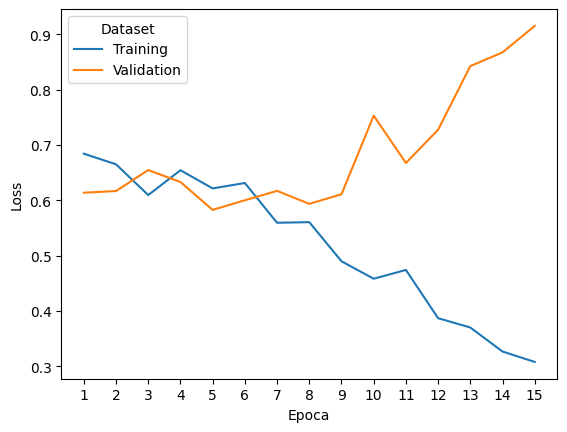

In [87]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{model_name}.pdf', dpi=300, bbox_inches='tight')
#plt.show()

In [93]:
output_predictions = trainer.predict(tokenized_val)

In [91]:
type(tokenized_val['labels'])

list

In [96]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [101]:
y_val = tokenized_val["labels"]
y_val_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.59      0.67       279
           1       0.67      0.84      0.74       273

    accuracy                           0.71       552
   macro avg       0.73      0.71      0.71       552
weighted avg       0.73      0.71      0.71       552



AttributeError: ignored

In [102]:
with open(f"class_report_{model_name}.html", "w") as file:
    file.write(report)

In [98]:
import matplotlib.pyplot as plt

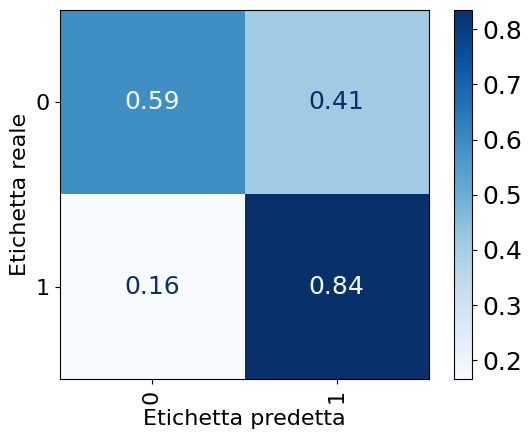

In [99]:
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, xticks_rotation='vertical', cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'conf_matrix_{model_name}.pdf', dpi=300, bbox_inches='tight')
plt.show()